In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import random

Set seeds

In [2]:
seed_value = 52
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

## Prepare Data 


Additionally, visualize the data

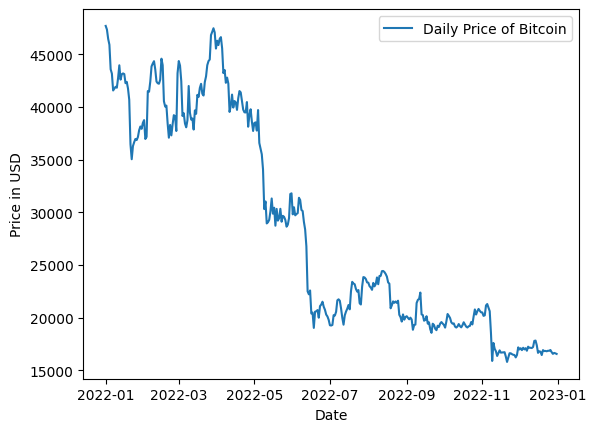

In [3]:
#Load in data
df = pd.read_csv(r"C:\Users\Owner\Documents\Predicting-Bitcoin-Returns-with-Long-Short-Term-Memory-LSTM-Neural-Networks\BTC-USD.csv")

prices = df["Close"].values

dates = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
ts = pd.Series(prices, index=dates)

plt.plot(ts)
plt.legend(['Daily Price of Bitcoin'])
plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.show()

### Create log returns of bitcoin price

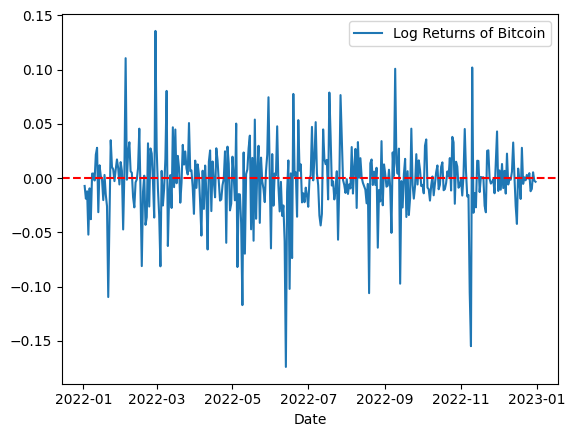

In [4]:
#Log price
log_P = np.log(prices)

#1st difference of ts to remove trend and seasonality
diff = np.diff(log_P)
diff = diff.astype('float32')


#Plot the modified data
dates_4_diff = pd.date_range(start='2022-01-02', end='2022-12-31', freq='D')
timeseries_indexed = pd.Series(diff, index=dates_4_diff)

plt.plot(timeseries_indexed)
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(["Log Returns of Bitcoin"])
plt.xlabel("Date")
plt.show()

Check dimensions

In [5]:
print(diff.shape)

(364,)


### Use ADF Test to check for stationarity


In [6]:
unit_test = adfuller(diff)

#Print results
print('ADF Statistic: %f' % unit_test[0])
print('p-value: %f' % unit_test[1])
print('Critical Values:', unit_test[4])

if unit_test[1] <= 0.05:
    print(f'Reject the null hypothesis. The time-series is stationary.')
else: 
    print(f"Fail to reject the null hypothesis. The time-series is non-stationary")


ADF Statistic: -19.230854
p-value: 0.000000
Critical Values: {'1%': -3.448493650810824, '5%': -2.8695352280356556, '10%': -2.5710293341377715}
Reject the null hypothesis. The time-series is stationary.


### Train-Validation-Test Split

In [7]:
# train-test split for time series
train_size = int(len(diff) * 0.70)
train, rest = diff[:train_size], diff[train_size:]
validation_size = int(len(rest) * 0.50)
validation, test = rest[:validation_size], rest[validation_size:]

print(len(train))
print(len(validation))
print(len(test))

254
55
55


### Create tensor dataset

In [8]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        inputs = dataset[i:i+lookback]
        labels = dataset[i+lookback:i+lookback+1]
        X.append(inputs)
        y.append(labels)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

lookback = 12
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_valid, y_valid = create_dataset(validation, lookback=lookback)

Inspect shape of tensors

In [9]:
print(f"X_train, y_train shape {X_train.shape, y_train.shape}")
print(f"X_valid, y_valid shape: {X_valid.shape, y_valid.shape}")
print(f"X_test, y_test shape: {X_test.shape, y_test.shape}")

X_train, y_train shape (torch.Size([242, 12]), torch.Size([242, 1]))
X_valid, y_valid shape: (torch.Size([43, 12]), torch.Size([43, 1]))
X_test, y_test shape: (torch.Size([43, 12]), torch.Size([43, 1]))


Reshape variables for LSTM

In [10]:
X_train = X_train.reshape(242, 12, 1)
X_valid = X_valid.reshape(43, 12, 1)
X_test = X_test.reshape(43, 12, 1)
y_train = y_train.reshape(242, 1, 1)
y_valid = y_valid.reshape(43, 1, 1)
y_test = y_test.reshape(43, 1, 1)

print(f"X_train, y_train shape {X_train.shape, y_train.shape}")
print(f"X_valid, y_valid shape: {X_valid.shape, y_valid.shape}")
print(f"X_test, y_test shape: {X_test.shape, y_test.shape}")

X_train, y_train shape (torch.Size([242, 12, 1]), torch.Size([242, 1, 1]))
X_valid, y_valid shape: (torch.Size([43, 12, 1]), torch.Size([43, 1, 1]))
X_test, y_test shape: (torch.Size([43, 12, 1]), torch.Size([43, 1, 1]))


## LSTM Class


In [11]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=1, num_layers=1, batch_first=True)
        self.linear = nn.Linear(1, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1:, :])
        return x
    def regularization(self, lambda_):
        reg_term = torch.tensor(0.0)
        for param in self.parameters():
            reg_term += torch.sum(param**2)
        return lambda_ * reg_term

## Training


In [12]:
model = LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=32)
n_epochs = 1000

for epoch in range(n_epochs+1):
    model.train()
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)

        #Loss
        loss = loss_fn(y_pred, y_batch)
        loss = torch.sqrt(loss)

        loss.backward()
        optimizer.step()
    # #Progress Printer
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        
        y_pred = model(X_valid)
        valid_rmse = torch.sqrt(loss_fn(y_pred, y_valid))
    print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, validation RMSE {valid_rmse:.4f}")

Epoch 0: train RMSE 0.0397, validation RMSE 0.0270
Epoch 10: train RMSE 0.0362, validation RMSE 0.0170
Epoch 20: train RMSE 0.0362, validation RMSE 0.0170
Epoch 30: train RMSE 0.0362, validation RMSE 0.0170
Epoch 40: train RMSE 0.0362, validation RMSE 0.0170
Epoch 50: train RMSE 0.0362, validation RMSE 0.0170
Epoch 60: train RMSE 0.0362, validation RMSE 0.0170
Epoch 70: train RMSE 0.0362, validation RMSE 0.0170
Epoch 80: train RMSE 0.0362, validation RMSE 0.0170
Epoch 90: train RMSE 0.0362, validation RMSE 0.0170
Epoch 100: train RMSE 0.0362, validation RMSE 0.0170
Epoch 110: train RMSE 0.0362, validation RMSE 0.0170
Epoch 120: train RMSE 0.0362, validation RMSE 0.0170
Epoch 130: train RMSE 0.0362, validation RMSE 0.0170
Epoch 140: train RMSE 0.0362, validation RMSE 0.0170
Epoch 150: train RMSE 0.0362, validation RMSE 0.0170
Epoch 160: train RMSE 0.0362, validation RMSE 0.0170
Epoch 170: train RMSE 0.0362, validation RMSE 0.0170
Epoch 180: train RMSE 0.0362, validation RMSE 0.0170
Epoc

Use this to select the optimal value of lambda 

In [13]:
# def reg_selection(dictionary):
#     """
#     Selects the optimal model based on RMSE

#     Input: Dictionary of lambda values and their corresponding RMSE scores
#     Output: Optimal value of Lambda

#     """

#     rmse = None
#     reg_term = None

#     for key, value in dictionary.items():
#         if rmse is None:
#             rmse = value
#             reg_term = key
#         elif value < rmse:
#                 rmse = value
#                 reg_term = key

#     return reg_term      


# print(f"Select {reg_selection(model_select):.10f} as lambda")

## Plotting Results of LSTM



train RMSE 0.0362, validation RMSE 0.0170, test RMSE 0.0166


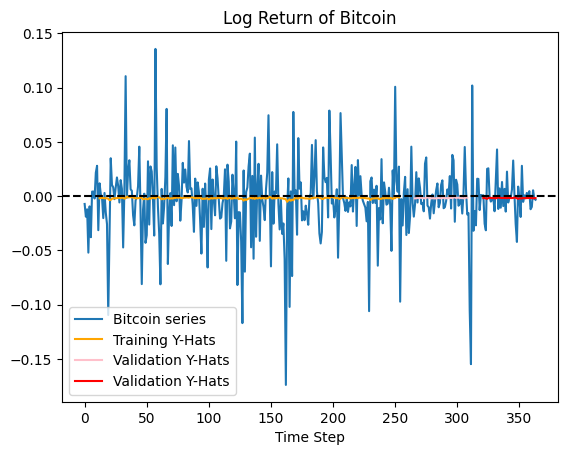

In [16]:
with torch.no_grad():
    ##Shift train predictions for plotting
    train_plot = np.ones_like(diff) * np.nan
    #get predictions for training set
    y_hat_train = model(X_train)
    #RMSE for training set
    rmse_train = torch.sqrt(loss_fn(y_hat_train, y_train))
    #Plot the training predictions
    y_hat_train = y_hat_train.reshape(242,)
    train_plot[lookback:train_size] = y_hat_train


    #Shift validation predictions for plotting
    valid_plot = np.ones_like(diff) * np.nan
    #Get predictions for valid set
    y_hat_valid = model(X_valid)
    #RMSE for valid set
    rmse_valid = torch.sqrt(loss_fn(y_hat_valid, y_valid))
    #Plot the valid predictions
    y_hat_valid = y_hat_valid.reshape(43,)
    valid_plot[train_size+lookback:train_size+len(y_valid)+lookback] = y_hat_valid

    #Shift test predictions for plotting
    test_plot = np.ones_like(diff) * np.nan
    #Get predictions for testing set
    y_hat_test = model(X_test)
    #RMSE for testing set
    rmse_test = torch.sqrt(loss_fn(y_hat_test, y_test))
    #Plot the testing predictions
    y_hat_test = y_hat_test.reshape(43,)
    test_plot[train_size+lookback+len(y_valid)+lookback:] = y_hat_test

print(f"train RMSE {rmse_train:.4f}, validation RMSE {rmse_valid:.4f}, test RMSE {rmse_test:.4f}")


# plot
plt.plot(diff, label='Bitcoin series')
plt.plot(train_plot, c='orange', label="Training Y-Hats")
plt.plot(valid_plot, c='pink', label='Validation Y-Hats')
plt.plot(test_plot, c='r', label='Validation Y-Hats')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
# plt.savefig("365 forecast")
plt.show()

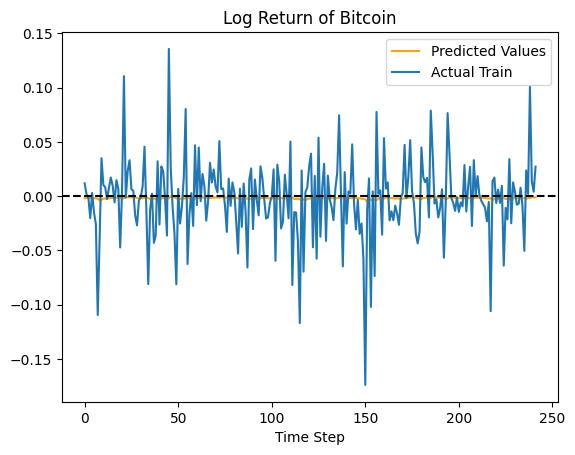

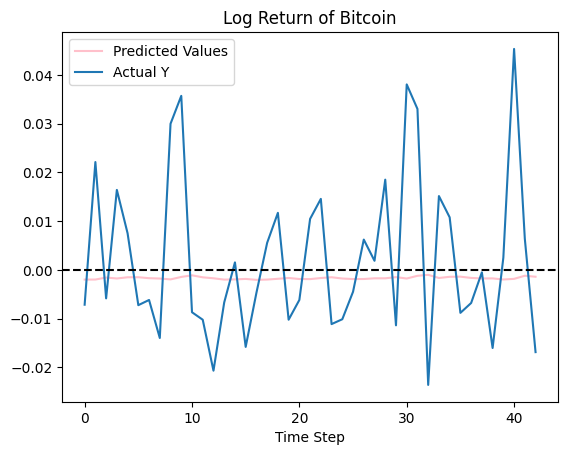

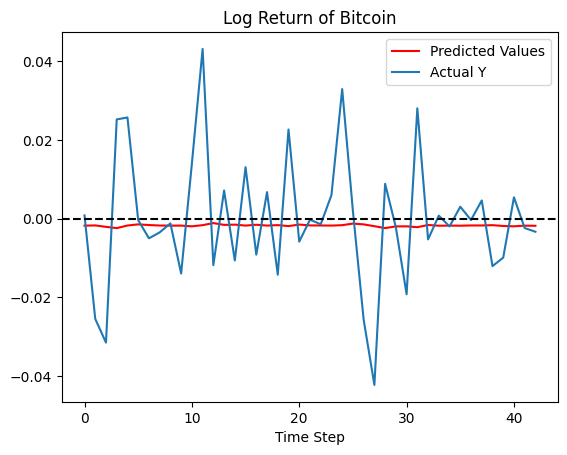

In [15]:
plt.plot(y_hat_train, c='orange', label="Predicted Values")
plt.plot(y_train.squeeze(), label="Actual Train")
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
# plt.savefig("Trained.png")
plt.show()


plt.plot(y_hat_valid, c='pink', label="Predicted Values")
plt.plot(y_valid.squeeze(), label="Actual Y")
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
# plt.savefig("Valid.png")
plt.show()

plt.plot(y_hat_test, c='red', label="Predicted Values")
plt.plot(y_test.squeeze(), label="Actual Y")
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
# plt.savefig("Valid.png")
plt.show()